In [1]:
import base64
import collections
import functools
import io
import json
import logging
import pathlib
import typing
import uuid

from PIL import Image
from PIL import ImageChops

from pikov import GuidNode, StringNode, Int64Node, JSONGraph
from pikov.pikov import SemanticGraphNode
from pikov.properties import make_guid_property, StringProperty, Int64Property

In [2]:
# Helper for displaying images.

# source: http://nbviewer.ipython.org/gist/deeplook/5162445
from io import BytesIO

from IPython import display
from PIL import Image


def display_pil_image(im):
   """Displayhook function for PIL Images, rendered as PNG."""

   b = BytesIO()
   im.save(b, format='png')
   data = b.getvalue()

   ip_img = display.Image(data=data, format='png', embed=True)
   return ip_img._repr_png_()


# register display func with PNG formatter:
png_formatter = get_ipython().display_formatter.formatters['image/png']
dpi = png_formatter.for_type(Image.Image, display_pil_image)

In [3]:
sample_dir = (pathlib.Path("..") / ".." / "samples").resolve()

with open(sample_dir / "pikov-core.json") as fp:
    core_types = json.load(fp)
    #graph = JSONGraph.load(fp)

In [4]:
sample_path = sample_dir / "gamekitty.json"

# Merge core types into pikov.json
graph = JSONGraph.load(sample_path)
for key, item in core_types["guidMap"].items():
    graph._guid_map[key] = item

## Build names mapping

To make it a little easier to check that I'm using the correct guids, construct a mapping from names back to `guid`.

Note: this adds a constraint that no two nodes have the same name, which should not be enforced for general semantic graphs.

In [5]:
names = {}
for node in graph:
    for edge in node:
        if edge.guid == "169a81aefca74e92b45e3fa03c7021df":
            value = node[edge].value
            if value in names:
                raise ValueError('name: "{}" defined twice'.format(value))
            names[value] = node
     
names["ctor"]

GuidNode(guid="aba6ac79fd3d409da860a77c90942852")

In [6]:
# {name: names[name].guid for name in sorted(names) if '[' not in name}

In [7]:
def name_to_guid(name):
    if name not in names:
        return None
    node = names[name]
    if not hasattr(node, "guid"):
        return None
    return node.guid

### Pikov sprite editor classes

These classes are the core resources used in defining a "Pikov" file.

Note: ideally these classes could be derived from the graph itself, but I
don't (yet) encode type or field information in the `pikov.json` semantic
graph.

In [8]:
from pikov.sprite import Resource, Rectangle, Point, Bitmap

## Gamekitty

Create instances of the Pikov classes to define a concrete Pikov graph, based on my "gamekitty" animations.

In [9]:
resource = Resource(graph, guid=name_to_guid("spritesheet"))
resource.name = "spritesheet"
resource.relative_path = "./gamekitty.png"
resource

Resource(guid="710af736fb3945e28b07e0ac3a8e53d6")

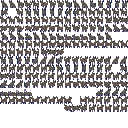

In [10]:
resource.image

### Chop image into 8x8 sprites

By creating an array of 8x8 images, we make it easier to map from PICO-8 sprite number (from my original gamekitty cart) to a Bitmap.

In [11]:
spritesheet = []
for row in range(16):
    for column in range(16):
        sprite_number = row * 16 + column
        
        crop_name = "crop[{}]".format(sprite_number)
        crop = Rectangle(graph, guid=name_to_guid(crop_name))
        crop.name = crop_name
        
        anchor_name = "anchor[{}]".format(sprite_number)
        anchor = Point(graph, guid=name_to_guid(anchor_name))
        anchor.name = anchor_name
        anchor.x = column * 8
        anchor.y = row * 8

        crop.anchor = anchor
        crop.width = 8
        crop.height = 8
        
        bitmap_name = "bitmap[{}]".format(sprite_number)
        bitmap = Bitmap(graph, guid=name_to_guid(bitmap_name))
        bitmap.name = bitmap_name
        bitmap.resource = resource
        bitmap.crop = crop
        
        spritesheet.append(bitmap)

In [12]:
list(graph.get_labels(spritesheet[4]))
spritesheet[1].image

In [13]:
# Save our work!
graph.save()